# Drone 2 Hyper-parameters Tuning

## Introduction: 

This is the second part of the entire model selection process, which is also specifically focused on tuning the classifiers, gradient boosting and random forest, for drone 2. Without further ado, let's get right into it.

## Load Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.grid_search_utils import *
from utils.data_visualization_utils import *
from utils.metrics_utils import get_confusion_matrix

from utils.data_storage import DataContianer

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

In [3]:
# constant variables: name for each drone.
drone2 = "drone2"

## Load Drone 2 Data

In [3]:
# instantiate an object that contains training and test data for Drone 2.
drone2_gyro_data = DataContianer(drone2, 'gyro', 4)

In [4]:
X_train_d2 = drone2_gyro_data.X_train_transformed
y_train_d2 = drone2_gyro_data.y_train_transformed
X_test_d2 = drone2_gyro_data.X_test_transformed
y_test_d2 = drone2_gyro_data.y_test_transformed

## (1) Random Forest

#### Baseline Model

Let's get a baseline random forest classifier without any tuning.

The default parameters that sklearn chooses for random forest classifiers that we are also going to tune are the followings:
- n_estimators = 10
- max_features=sqrt(n_features)
- max_depth = None
- min_samples_split = 2
- min_samples_leaf = 1

In [5]:
rf_baseline_d2 = RandomForestClassifier(random_state = 13)

In [6]:
report_model_score(rf_baseline_d2, X_train_d2, y_train_d2)

Model Report: 
Mean cv score: 0.877 +/- std: 0.020


The mean cv score for our baseline model is <font color=blue> 0.877 </font>, with a standard deviation of <font color=blue> 0.020 </font>.

Then, let's look at the confusion matrix.

In [7]:
_ = rf_baseline_d2.fit(X_train_d2, y_train_d2)

### Visualize Confusion Matrix

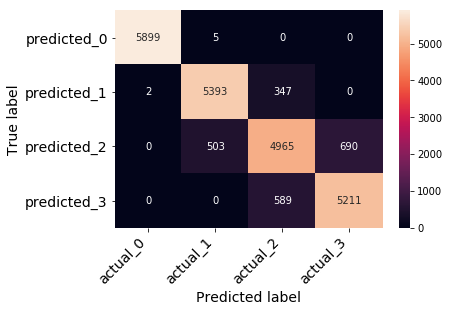

In [8]:
y_pred_d2_rf = rf_baseline_d2.predict(X_test_d2)
plot_confusion_matrix(get_confusion_matrix(y_pred_d2_rf, y_test_d2))

### Test Accuracy

In [9]:
print('The test accuracy for baseline model (rf) is {:.3f}'.
      format(rf_baseline_d2.score(X_test_d2, y_test_d2)))

The test accuracy for baseline model (rf) is 0.910


## Hyper-parameters Tuning

#### Step 1: Finding the best initial number of estimators

In [10]:
rf_d2 = RandomForestClassifier(min_samples_split=500, min_samples_leaf=50,
                               max_depth=8, max_features='sqrt', random_state=13)

param_test1_rf_d2 = {"n_estimators": np.arange(20, 81, 20)}

In [11]:
grid_search = GridSearchCV(rf_d2, param_grid=param_test1_rf_d2, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d2, y_train_d2)

In [12]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.8795, Standard Deviation: 0.0164
Parameters: {'n_estimators': 80}

Model with rank: 2
Mean validation score: 0.8794, Standard Deviation: 0.0174
Parameters: {'n_estimators': 60}

Model with rank: 3
Mean validation score: 0.8787, Standard Deviation: 0.0184
Parameters: {'n_estimators': 20}



As we can see from the sumamry above, the best mean validation score is returned when n_estimators is 80. This also means that a higher number of estimators could give us a better result. Thus, further tuning is required for this parameter later.

### Step 2: Tuning max_depth, min_samples_split, min_samples_leaf and max_features

In [13]:
rf_d2 = RandomForestClassifier(n_estimators=80, min_samples_leaf=50, max_features='sqrt', random_state=13)

param_test2_rf_d2 = {
    "max_depth": range(5, 16, 3),
    "min_samples_split": range(200, 1000, 200)
}

In [14]:
grid_search = GridSearchCV(rf_d2, param_grid=param_test2_rf_d2, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d2, y_train_d2)

In [15]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.8849, Standard Deviation: 0.0170
Parameters: {'max_depth': 11, 'min_samples_split': 400}

Model with rank: 2
Mean validation score: 0.8842, Standard Deviation: 0.0164
Parameters: {'max_depth': 14, 'min_samples_split': 400}

Model with rank: 3
Mean validation score: 0.8841, Standard Deviation: 0.0172
Parameters: {'max_depth': 14, 'min_samples_split': 200}



When max_depth is set to 11 and min_samples_split is 400 gave us the highest mean cv score. We will use this combination for max_features and min_samples_split in the later tuning.

Next, our objective is to find the best value for <b>min_samples_leaf</b>

In [16]:
rf_d2 = RandomForestClassifier(n_estimators=80, max_features='sqrt', max_depth=11, min_samples_split=400, random_state=13)

param_test3_rf_d2 = {
    "min_samples_leaf": range(30, 71, 10),
}

In [17]:
grid_search = GridSearchCV(rf_d2, param_grid=param_test3_rf_d2, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d2, y_train_d2)

In [18]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.8849, Standard Deviation: 0.0170
Parameters: {'min_samples_leaf': 50}

Model with rank: 2
Mean validation score: 0.8848, Standard Deviation: 0.0164
Parameters: {'min_samples_leaf': 30}

Model with rank: 3
Mean validation score: 0.8840, Standard Deviation: 0.0163
Parameters: {'min_samples_leaf': 60}



The result has shown us that the default we picked for min_samples_leaf (50) is already the optimum value.

In [19]:
rf_d2 = RandomForestClassifier(n_estimators=80, min_samples_split=140, min_samples_leaf=50,
                               max_depth=14, random_state=13)

param_test4_rf_d2 = {
    "max_features": range(6, 17, 2)
}

In [20]:
grid_search = GridSearchCV(rf_d2, param_grid=param_test4_rf_d2, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d2, y_train_d2)

In [21]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.8851, Standard Deviation: 0.0183
Parameters: {'max_features': 6}

Model with rank: 2
Mean validation score: 0.8851, Standard Deviation: 0.0177
Parameters: {'max_features': 8}

Model with rank: 3
Mean validation score: 0.8838, Standard Deviation: 0.0188
Parameters: {'max_features': 16}



In our experiment, the total number of features is 40. Therefore, the default value is around 6 (the square root of 40). The result above shows us that the default value is already the best value for our max_features. 

In [22]:
rf_d2 = RandomForestClassifier(n_estimators=80, max_features=6, min_samples_split=140, min_samples_leaf=50,
                               max_depth=14, random_state=13)

param_test5_rf_d2 = {
    "n_estimators": range(80, 200, 20)
}

In [23]:
grid_search = GridSearchCV(rf_d2, param_grid=param_test5_rf_d2, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d2, y_train_d2)

In [24]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.8854, Standard Deviation: 0.0184
Parameters: {'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.8852, Standard Deviation: 0.0179
Parameters: {'n_estimators': 120}

Model with rank: 3
Mean validation score: 0.8851, Standard Deviation: 0.0178
Parameters: {'n_estimators': 140}



After retuning the number of estimators, we found out that when it is set to 100, we have the highest mean cv score, 88.54%. The baseline model gave us a 87.7% mean cv score, which is only marginally smaller than the tuned model. However, the model is already way more complex than the baseline model. In this situation, we should follow occam's razor and pick the simplier model. Nevertheless, let's look at how the fine-tuned model performes on the test set.

## Final Random Forest Model, Drone 2

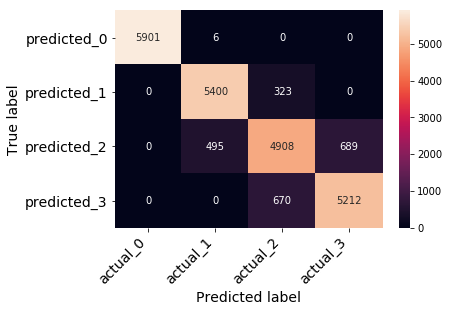

In [25]:
rf_d2_final = grid_search
y_pred_d2_rf = rf_d2_final.predict(X_test_d2)
plot_confusion_matrix(get_confusion_matrix(y_pred_d2_rf, y_test_d2))

In [26]:
print('The test accuracy for final model (rf) is {:.4f}'.
      format(rf_d2_final.score(X_test_d2, y_test_d2)))

The test accuracy for final model (rf) is 0.9075


# Conclusion

Even though the final model is way complex than the baseline model, the test accuracy is almost equal to the one of our baseline model, which gives more confidence in choosing the baseline model over the fine tuned one.

## (1) Gradient Boosting

As usual, let's get a baseline classifier first

The default parameters that sklearn chooses for gradient boosting classifiers are the followings:
- learning_rate = 0.1
- n_estimators = 100
- max_features=sqrt(n_features)
- max_depth = 3
- min_samples_split = 2
- min_samples_leaf = 1
- subsample = 1.0

In [27]:
gb_baseline_d2 = GradientBoostingClassifier(random_state = 13)

In [28]:
report_model_score(gb_baseline_d2, X_train_d2, y_train_d2)

Model Report: 
Mean cv score: 0.888 +/- std: 0.021


In [29]:
_ = gb_baseline_d2.fit(X_train_d2, y_train_d2)

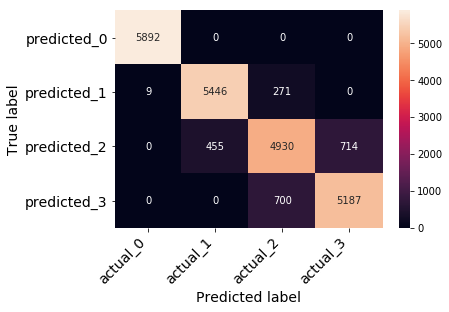

In [30]:
y_pred_d2_gb = gb_baseline_d2.predict(X_test_d2)
plot_confusion_matrix(get_confusion_matrix(y_pred_d2_gb, y_test_d2))

In [31]:
print('The test accuracy for baseline model (gb) is {:.3f}'.
      format(gb_baseline_d2.score(X_test_d2, y_test_d2)))

The test accuracy for baseline model (gb) is 0.909


## Hyper-parameters Tuning

#### Step 1: Finding the best initial combination of n_estimators and learning_rate

In [32]:
gb_d2 = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500, min_samples_leaf=50,
                                    max_depth=8, max_features='sqrt', subsample=0.8, random_state=13)

param_test1_gb_d2 = {'n_estimators':range(20,81,20)}

In [33]:
grid_search = GridSearchCV(gb_d2, param_grid=param_test1_gb_d2, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d2, y_train_d2)

In [34]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.8880, Standard Deviation: 0.0187
Parameters: {'n_estimators': 60}

Model with rank: 2
Mean validation score: 0.8879, Standard Deviation: 0.0184
Parameters: {'n_estimators': 80}

Model with rank: 3
Mean validation score: 0.8864, Standard Deviation: 0.0200
Parameters: {'n_estimators': 40}



In [35]:
gb_d2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, min_samples_leaf=50,
                                   max_features='sqrt', subsample=0.8, random_state=13)

param_test2_gb_d2 = {
    "max_depth": range(5, 15, 3),
    "min_samples_split": range(200, 601, 200)
}

In [36]:
grid_search = GridSearchCV(gb_d2, param_grid=param_test2_gb_d2, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d2, y_train_d2)

In [37]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.8898, Standard Deviation: 0.0189
Parameters: {'max_depth': 14, 'min_samples_split': 600}

Model with rank: 2
Mean validation score: 0.8889, Standard Deviation: 0.0171
Parameters: {'max_depth': 11, 'min_samples_split': 400}

Model with rank: 3
Mean validation score: 0.8887, Standard Deviation: 0.0197
Parameters: {'max_depth': 8, 'min_samples_split': 600}



The results show us that there could be a higher value for max_depth and min_samples_split that provides a better mean cv score. Therefore, we need to re-tune max_depth and min_samples_split as a combination again.

In [38]:
gb_d2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, min_samples_leaf=50,
                                   max_features='sqrt', subsample=0.8, random_state=13)

param_test3_gb_d2 = {
    "max_depth": range(14, 17, 1),
    "min_samples_split": range(600, 1000, 200)
}

In [39]:
grid_search = GridSearchCV(gb_d2, param_grid=param_test3_gb_d2, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d2, y_train_d2)

In [40]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.8898, Standard Deviation: 0.0189
Parameters: {'max_depth': 14, 'min_samples_split': 600}

Model with rank: 2
Mean validation score: 0.8895, Standard Deviation: 0.0191
Parameters: {'max_depth': 14, 'min_samples_split': 800}

Model with rank: 3
Mean validation score: 0.8886, Standard Deviation: 0.0192
Parameters: {'max_depth': 16, 'min_samples_split': 800}



It turns our that when max_depth is 14 and min_samples_split is 600 gives us the best mean cv score.

In [46]:
gb_d2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_depth=14,
                                   min_samples_split = 600,
                                   max_features='sqrt', subsample=0.8, random_state=13)

param_test4_gb_d2 = {
    "min_samples_leaf": range(30,71,10)
}

In [47]:
grid_search = GridSearchCV(gb_d2, param_grid=param_test4_gb_d2, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d2, y_train_d2)

In [48]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.8898, Standard Deviation: 0.0189
Parameters: {'min_samples_leaf': 50}

Model with rank: 2
Mean validation score: 0.8896, Standard Deviation: 0.0188
Parameters: {'min_samples_leaf': 60}

Model with rank: 3
Mean validation score: 0.8883, Standard Deviation: 0.0187
Parameters: {'min_samples_leaf': 30}



In [49]:
gb_d2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_depth=14,
                                   min_samples_split = 600,
                                   min_samples_leaf=50, subsample=0.8, random_state=13)

param_test5_gb_d2 = {
    "max_features": range(6, 17, 2)
}

In [50]:
grid_search = GridSearchCV(gb_d2, param_grid=param_test5_gb_d2, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d2, y_train_d2)

In [51]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.8898, Standard Deviation: 0.0189
Parameters: {'max_features': 6}

Model with rank: 2
Mean validation score: 0.8887, Standard Deviation: 0.0169
Parameters: {'max_features': 14}

Model with rank: 3
Mean validation score: 0.8882, Standard Deviation: 0.0177
Parameters: {'max_features': 10}



In [52]:
gb_d2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_depth=11,
                                   min_samples_split=200, max_features=6,
                                   min_samples_leaf=50, random_state=13)

param_test5_gb_d2 = {
    "subsample": [0.6, 0.7, 0.8, 0.9]
}

In [53]:
grid_search = GridSearchCV(gb_d2, param_grid=param_test5_gb_d2, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_d2, y_train_d2)

In [54]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.8883, Standard Deviation: 0.0182
Parameters: {'subsample': 0.6}

Model with rank: 2
Mean validation score: 0.8880, Standard Deviation: 0.0182
Parameters: {'subsample': 0.7}

Model with rank: 3
Mean validation score: 0.8878, Standard Deviation: 0.0182
Parameters: {'subsample': 0.9}



Re-tuning subsample brought down the mean cv score slightly, thus, we will choose 0.8 instead.

In [59]:
gb_d2_final = GradientBoostingClassifier(learning_rate=0.05, n_estimators=120, max_depth=11,
                                   min_samples_split=200, max_features=6, subsample=0.8,
                                   min_samples_leaf=50, random_state=13)

In [60]:
report_model_score(gb_d2_final, X_train_d2, y_train_d2)

Model Report: 
Mean cv score: 0.889 +/- std: 0.019


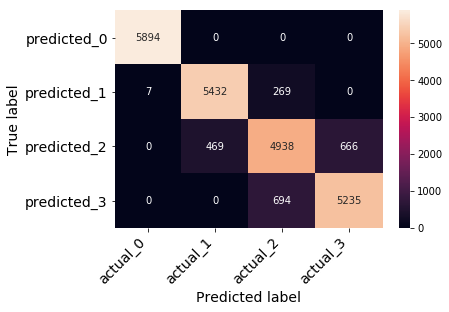

In [62]:
gb_d2_final.fit(X_train_d2, y_train_d2)
y_pred_d2_gb = gb_d2_final.predict(X_test_d2)
plot_confusion_matrix(get_confusion_matrix(y_pred_d2_gb, y_test_d2))

In [63]:
print('The test accuracy for final model (gb) is {:.4f}'.
      format(gb_d2_final.score(X_test_d2, y_test_d2)))

The test accuracy for final model (gb) is 0.9108


The final model yielded a mean cv score of 88.9% and an accuracy of 91%, both of which are higher than what the baseline model produced. However, again, according to occam's razor law, we will choose the baseline model because its simplicity.

## Directional Data

## Load Data

In [4]:
# instantiate an object that contains training and test data for drone 1.
drone2_gyro_directional = DataContianer('drone2', 'acc', 4, is_directional=True)

In [5]:
X_train_directional_d2 = drone2_gyro_directional.X_train_transformed
y_train_directional_d2 = drone2_gyro_directional.y_train_transformed
X_test_directional_d2 = drone2_gyro_directional.X_test_transformed
y_test_directional_d2 = drone2_gyro_directional.y_test_transformed

## (1) Random Forest

Let's get a baseline model first.

The default parameters that sklearn chooses for random forest classifiers are the followings:
- n_estimators = 10
- max_features=sqrt(n_features)
- max_depth = None
- min_samples_split = 2
- min_samples_leaf = 1

In [6]:
rf_baseline_directional_d2 = RandomForestClassifier(random_state = 13)

In [8]:
report_model_score(rf_baseline_directional_d2, X_train_directional_d2, y_train_directional_d2)

Model Report: 
Mean cv score: 0.949 +/- std: 0.013


In [9]:
_ = rf_baseline_directional_d2.fit(X_train_directional_d2, y_train_directional_d2)

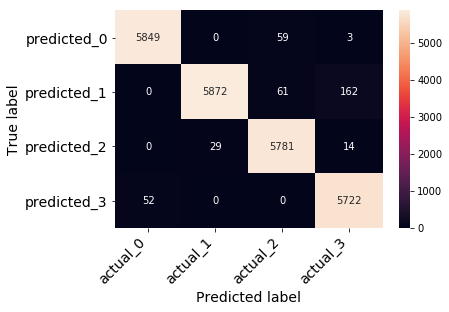

In [10]:
y_pred_d2_rf_directional = rf_baseline_directional_d2.predict(X_test_directional_d2)
plot_confusion_matrix(get_confusion_matrix(y_pred_d2_rf_directional, y_test_directional_d2))

In [11]:
print('The test accuracy for baseline model (rf, directional) is {:.3f}'.
      format(rf_baseline_directional_d2.score(X_test_directional_d2, y_test_directional_d2)))

The test accuracy for baseline model (rf, directional) is 0.984


## Hyper-parameters Tuning

In [12]:
rf_d2_directional = RandomForestClassifier(min_samples_split=500, min_samples_leaf=50,
                               max_depth=8, max_features='sqrt', random_state=13)

param_test2_rf_d2_directional = {"n_estimators": np.arange(20, 81, 20)}

In [13]:
grid_search = GridSearchCV(rf_d2_directional, param_grid=param_test2_rf_d2_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d2, y_train_directional_d2)

In [14]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9456, Standard Deviation: 0.0176
Parameters: {'n_estimators': 20}

Model with rank: 2
Mean validation score: 0.9452, Standard Deviation: 0.0209
Parameters: {'n_estimators': 60}

Model with rank: 3
Mean validation score: 0.9444, Standard Deviation: 0.0206
Parameters: {'n_estimators': 40}



The results indicated that 20 estimators are sufficient in our setting.

In [15]:
rf_d2_directional = RandomForestClassifier(n_estimators=20, min_samples_leaf=50, max_features='sqrt', random_state=13)

param_test2_rf_d2_directional = {
    "max_depth": range(5, 16, 3),
    "min_samples_split": range(200, 1000, 200)
}

In [17]:
grid_search = GridSearchCV(rf_d2_directional, param_grid=param_test2_rf_d2_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d2, y_train_directional_d2)

In [18]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9475, Standard Deviation: 0.0191
Parameters: {'max_depth': 14, 'min_samples_split': 200}

Model with rank: 2
Mean validation score: 0.9470, Standard Deviation: 0.0176
Parameters: {'max_depth': 14, 'min_samples_split': 600}

Model with rank: 3
Mean validation score: 0.9469, Standard Deviation: 0.0180
Parameters: {'max_depth': 11, 'min_samples_split': 200}



In [19]:
rf_d2_directional = RandomForestClassifier(n_estimators=20, max_features='sqrt', 
                                           max_depth=14, min_samples_split=200, random_state=13)

param_test3_rf_d2_directional = {
    "min_samples_leaf": range(30, 71, 10),
}

In [20]:
grid_search = GridSearchCV(rf_d2_directional, param_grid=param_test3_rf_d2_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d2, y_train_directional_d2)

In [21]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9505, Standard Deviation: 0.0165
Parameters: {'min_samples_leaf': 40}

Model with rank: 2
Mean validation score: 0.9502, Standard Deviation: 0.0180
Parameters: {'min_samples_leaf': 70}

Model with rank: 3
Mean validation score: 0.9497, Standard Deviation: 0.0189
Parameters: {'min_samples_leaf': 30}



By setting min_samples_leaf to 40, we are able to increase the mean cv score to 95.05%.

In [22]:
rf_d2_directional = RandomForestClassifier(n_estimators=20, min_samples_split=200,
                                           min_samples_leaf=40, max_depth=14, random_state=13)

param_test4_rf_d2_directional = {
    "max_features": range(6, 17, 2)
}

In [23]:
grid_search = GridSearchCV(rf_d2_directional, param_grid=param_test4_rf_d2_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d2, y_train_directional_d2)

In [24]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9554, Standard Deviation: 0.0137
Parameters: {'max_features': 14}

Model with rank: 2
Mean validation score: 0.9551, Standard Deviation: 0.0136
Parameters: {'max_features': 10}

Model with rank: 3
Mean validation score: 0.9550, Standard Deviation: 0.0135
Parameters: {'max_features': 16}



Tuning max_features further improved the mean cv score. However, the effect of tuning did not gave a drastic improvement. The mean cv score improved slowly after each round of tuning, which means our model has almost reached its upper bound, in terms of mean cv score.

In [42]:
rf_d2_directional = RandomForestClassifier(max_features=14, min_samples_split=200, 
                                           min_samples_leaf=60, max_depth=14, random_state=13)

param_test5_rf_d2_directional = {
    "n_estimators": range(80, 200, 20)
}

In [43]:
grid_search = GridSearchCV(rf_d2_directional, param_grid=param_test5_rf_d2_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d2, y_train_directional_d2)

In [44]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9568, Standard Deviation: 0.0130
Parameters: {'n_estimators': 140}

Model with rank: 2
Mean validation score: 0.9568, Standard Deviation: 0.0125
Parameters: {'n_estimators': 180}

Model with rank: 3
Mean validation score: 0.9568, Standard Deviation: 0.0125
Parameters: {'n_estimators': 160}



The final model returned a 95.68% mean cv score, which is marginally greater than the one of baseline model. However, the final model requires to use 140 estimators, which is way more than what baseline model uses, which is 10. At this point, we have decided to use the baseline model.

## Final Random Forest Model, Drone 2

In [45]:
rf_d2_directional_final = RandomForestClassifier(n_estimators=140, max_features=14, min_samples_split=200, 
                                           min_samples_leaf=60, max_depth=14, random_state=13)

_ = rf_d2_directional_final.fit(X_train_directional_d2, y_train_directional_d2)

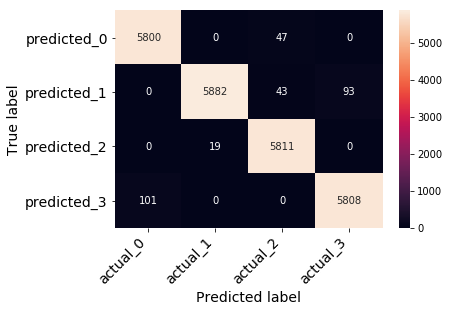

In [46]:
y_pred_d2_rf_directional = rf_d2_directional_final.predict(X_test_directional_d2)
plot_confusion_matrix(get_confusion_matrix(y_pred_d2_rf_directional, y_test_directional_d2))

In [47]:
print('The test accuracy for final model (rf, directional) is {:.3f}'.
      format(rf_d2_directional_final.score(X_test_directional_d2, y_test_directional_d2)))

The test accuracy for final model (rf, directional) is 0.987


## Conclusion

The final model performed equally well as the baseline model, but it is way more complex. We will go with the baseline model.

## (2) Gradient Boosting

As usual, let's get a baseline classifier first

The default parameters that sklearn chooses for gradient boosting classifiers are the followings:
- learning_rate = 0.1
- n_estimators = 100
- max_features=sqrt(n_features)
- max_depth = 3
- min_samples_split = 2
- min_samples_leaf = 1
- subsample = 1.0

In [48]:
gb_baseline_directional_d2 = GradientBoostingClassifier(random_state = 13)

In [49]:
report_model_score(gb_baseline_directional_d2, 
                   X_train_directional_d2, 
                   y_train_directional_d2)

Model Report: 
Mean cv score: 0.962 +/- std: 0.006


In [50]:
_ = gb_baseline_directional_d2.fit(X_train_directional_d2,
                                   y_train_directional_d2)

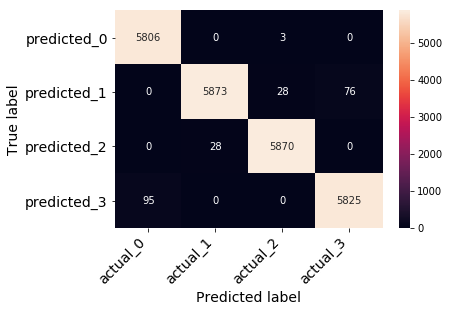

In [51]:
y_pred_d2_gb_directional = gb_baseline_directional_d2.predict(X_test_directional_d2)
plot_confusion_matrix(get_confusion_matrix(y_pred_d2_gb_directional,
                                           y_test_directional_d2))

In [52]:
print('The test accuracy for baseline model (gb, directional) is {:.3f}'.
      format(gb_baseline_directional_d2.score(X_test_directional_d2,
                                              y_test_directional_d2)))

The test accuracy for baseline model (gb, directional) is 0.990


At this point, the baseline model with default setting from sklearn has already performed extremely well on the test set. It also produced a mean cv score of 96.2%. We will not choose the baseline model unless a more complex model can perform perfectly.

## Hyper-parameters Tuning

#### Step 1: Finding the best initial number of estimators

Default values:
- learning_rate=0.1, 
- min_samples_split=500, 
- min_samples_leaf=50,
- max_depth=8, 
- max_features='sqrt', 
- subsample=0.8, 
- random_state=13

In [53]:
gb_d2_directional = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500, min_samples_leaf=50,
                                    max_depth=8, max_features='sqrt', subsample=0.8, random_state=13)

param_test1_gb_d2_directional = {'n_estimators':range(20,81,20)}

In [54]:
grid_search = GridSearchCV(gb_d2_directional, param_grid=param_test1_gb_d2_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d2,
                    y_train_directional_d2)

In [55]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9581, Standard Deviation: 0.0137
Parameters: {'n_estimators': 60}

Model with rank: 2
Mean validation score: 0.9577, Standard Deviation: 0.0139
Parameters: {'n_estimators': 80}

Model with rank: 3
Mean validation score: 0.9567, Standard Deviation: 0.0130
Parameters: {'n_estimators': 40}



The model ranking shows us 60 estimators is optimum for our setting. Thus, we will set n_estimators to 60 for now. We will re-tune n_estimators and learning_rate as a combination in the end.

In [56]:
gb_d2_directional = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, min_samples_leaf=50,
                                   max_features='sqrt', subsample=0.8, random_state=13)

param_test2_gb_d2_directional = {
    "max_depth": range(5, 15, 3),
    "min_samples_split": range(200, 601, 200)
}

In [57]:
grid_search = GridSearchCV(gb_d2_directional, param_grid=param_test2_gb_d2_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d2,
                    y_train_directional_d2)

In [58]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9603, Standard Deviation: 0.0134
Parameters: {'max_depth': 5, 'min_samples_split': 200}

Model with rank: 2
Mean validation score: 0.9603, Standard Deviation: 0.0136
Parameters: {'max_depth': 11, 'min_samples_split': 400}

Model with rank: 3
Mean validation score: 0.9602, Standard Deviation: 0.0123
Parameters: {'max_depth': 14, 'min_samples_split': 400}



The results showed us that the max_depth and min_samples_split should be set to 5 and 200.

In [60]:
gb_d2_directional = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,
                                            max_depth=5, max_features='sqrt',
                                            min_samples_split=200, subsample=0.8, random_state=13)
param_test3_gb_d2_directional = {
    "min_samples_leaf": range(30,71,10)
}

In [61]:
grid_search = GridSearchCV(gb_d2_directional, param_grid=param_test3_gb_d2_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d2,
                    y_train_directional_d2)

In [62]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9603, Standard Deviation: 0.0134
Parameters: {'min_samples_leaf': 50}

Model with rank: 2
Mean validation score: 0.9599, Standard Deviation: 0.0120
Parameters: {'min_samples_leaf': 30}

Model with rank: 3
Mean validation score: 0.9592, Standard Deviation: 0.0142
Parameters: {'min_samples_leaf': 60}



In [63]:
gb_d2_directional = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,
                                            max_depth=5, min_samples_leaf=50,
                                            min_samples_split=200, subsample=0.8, random_state=13)
param_test4_gb_d2_directional = {
    "max_features": range(6, 17, 2)
}

In [64]:
grid_search = GridSearchCV(gb_d2_directional, param_grid=param_test4_gb_d2_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d2,
                    y_train_directional_d2)

In [65]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9631, Standard Deviation: 0.0072
Parameters: {'max_features': 16}

Model with rank: 2
Mean validation score: 0.9626, Standard Deviation: 0.0084
Parameters: {'max_features': 14}

Model with rank: 3
Mean validation score: 0.9624, Standard Deviation: 0.0095
Parameters: {'max_features': 10}



In [69]:
gb_d2_directional = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,
                                            max_depth=5, min_samples_leaf=50,
                                            min_samples_split=200, random_state=13)
param_test5_gb_d2_directional = {
    "max_features": range(16, 23, 2),
    "subsample": [0.6, 0.7, 0.8, 0.9]
}

In [70]:
grid_search = GridSearchCV(gb_d2_directional, param_grid=param_test5_gb_d2_directional, cv=3, n_jobs=-1)
_ = grid_search.fit(X_train_directional_d2,
                    y_train_directional_d2)

In [71]:
report(grid_search.grid_scores_, 3)

Model with rank: 1
Mean validation score: 0.9633, Standard Deviation: 0.0074
Parameters: {'max_features': 20, 'subsample': 0.7}

Model with rank: 2
Mean validation score: 0.9632, Standard Deviation: 0.0071
Parameters: {'max_features': 18, 'subsample': 0.9}

Model with rank: 3
Mean validation score: 0.9631, Standard Deviation: 0.0072
Parameters: {'max_features': 16, 'subsample': 0.8}



In [73]:
gb_d2_directional_final = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,
                                            max_depth=5, max_features=20,
                                            min_samples_leaf=50, subsample=0.7,
                                            min_samples_split=200, random_state=13)

_ = gb_d2_directional_final.fit(X_train_directional_d2,
                     y_train_directional_d2)

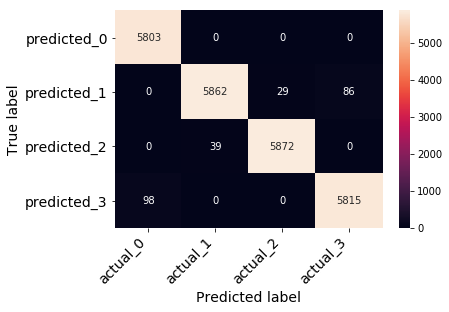

In [75]:
y_pred_d2_gb_directional = gb_d2_directional_final.predict(X_test_directional_d2)
plot_confusion_matrix(get_confusion_matrix(y_pred_d2_gb_directional,
                                           y_test_directional_d2))

In [77]:
print('The test accuracy for final model (gb, directional) is {:.3f}'.
      format(gb_d2_directional_final.score(X_test_directional_d2,
                                    y_test_directional_d2)))

The test accuracy for final model (gb, directional) is 0.989


## Conclusion

After a long tuning process, we are able to squeeze out some improvement on the meancv score, which is only 0.001 higher than the one produced by the baseline model. However, the baseline model is simplier than the final model. As a result, we decided to choose the baseline model over the final model.

# Summary

Here are the models we picked for drone 2:
- Wind Detection: <b>default</b> sklearn random forest and <b>default</b> gradient boosting.
- Direction Detection: <b>default</b> randome forest and <b>default</b> gradient boosting.